In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import random
import copy
import packages.baseline_model as baselibe_model
import packages.common_functions as common_functions
from skimage import io
import cv2
import packages.trans_in_rgb as trans_in_rgb
import matplotlib.pyplot as plt
import packages.CL_model as CL_model
from jpeg2dct.numpy import load, loads
from tqdm import tqdm

2022-06-06 18:12:58.604799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class RGBProjectionHead(tf.keras.Model):
    """
    projection head for contrastive learning
    """

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(512, bias_initializer=tf.keras.initializers.constant(0.01),
                                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                            bias_regularizer=regularizers.l2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(256, bias_initializer=tf.keras.initializers.constant(0.01),
                                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                            bias_regularizer=regularizers.l2(1e-4))
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, input, training=None):
        x = self.dense1(input)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        output = self.dense2(x)

        return output

In [3]:
class Resnet18_BaseEncoder(tf.keras.Model):

    def __init__(self, layer_params=None, method="late_concate"):
        super(Resnet18_BaseEncoder, self).__init__()

        self.method = method
        if layer_params is None:
            layer_params = [2, 2, 2, 2]
        self.y_input_bn = tf.keras.layers.BatchNormalization()
        self.cbcr_input_bn = tf.keras.layers.BatchNormalization()

        self.layer1_y = make_basic_block_layer(filter_num=64,
                                             blocks=2, dimen_match=True) # y:56,56,64
        self.cb2_y = make_basic_block_layer(filter_num=128,
                                             blocks=2, stride=2) # y:28,28,128
        self.cb2_cbcr = tf.keras.layers.Conv2D(filters=128,
                                               kernel_size=(1,1),
                                               strides=1,
                                               padding="same")
        self.cb_bn = tf.keras.layers.BatchNormalization()
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=2, # 14,14,512
                                             stride=2)
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs, training=None, mask=None):
        y = self.y_input_bn(inputs[0], training=training)
        cb_cr = self.cbcr_input_bn(inputs[1], training=training)

        y = self.layer1_y(y, training=training) # 56,56,64
        y = self.cb2_y(y, training=training) # 28,28,128
        cb_cr = tf.nn.relu(self.cb_bn(self.cb2_cbcr(cb_cr), training=training)) #28,28,128
        x = tf.concat((y, cb_cr), axis=3) #28,28,256
        x = self.layer4(x, training=training) #14,14,512
        x = self.avgpool(x)
        output = self.flatten(x)

        return output


def make_basic_block_layer(filter_num, blocks, k_size=(3,3), stride=1, dimen_match=False):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, k_size=k_size, stride=stride, dimen_match=dimen_match))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, k_size=(3,3), stride=1, dimen_match=False):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=k_size,
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=k_size,
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1 or dimen_match is True:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

In [4]:
# Define hyper parameters
batch_size = 128
tau = 0.1

# Define base encoder and projection head
feature_extractor = Resnet18_BaseEncoder()
projection_head = RGBProjectionHead()

labels = np.load("/home/lingyu/CL_gaze_project/ETHXgaze/Pretrain/labels.npy")
dataset_size = labels.shape[0]

# Define optimizers for contrastive learning
pic_num_list = np.load("/home/lingyu/CL_gaze_project/ETHXgaze/Pretrain_subject/pic_num_list.npy")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


# define batch for query and positive
query_batch_y = np.zeros((batch_size, 28, 28, 6))
query_batch_cbcr = np.zeros((batch_size, 14, 14, 6))
positive_batch_y = np.zeros((batch_size, 28, 28, 6))
positive_batch_cbcr = np.zeros((batch_size, 14, 14, 6))

trans_list = [1, 2]
error_list = []

2022-06-06 18:14:07.001746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:14:07.139966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:14:07.142203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:14:07.144753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [ ]:
# contrastive learning
for epoch in range(10000):

    index = np.random.choice(dataset_size, batch_size, replace=False)
    j = 0
    for i in index:
        jpeg_file = '/home/lingyu/CL_gaze_project/ETHXgaze/Pretrain/' + str(i) + '.jpg'
        img = io.imread(jpeg_file) / 255.
        selected_trans = random.sample(trans_list, 2)
        noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[0])
        noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[1])

        noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image1), selected_trans[1])
        noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image2), selected_trans[0])
        
        noised_image1 = cv2.resize(noised_image1, (224,224))
        noised_image2 = cv2.resize(noised_image2, (224,224))

        noised_image1 *= 255
        noised_image1 = np.round(noised_image1).astype(np.uint8)
        noised_image2 *= 255
        noised_image2 = np.round(noised_image2).astype(np.uint8)
        io.imsave("/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image1.jpg", noised_image1)
        io.imsave("/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image2.jpg", noised_image2)

        jpeg_noised = "/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image1.jpg"
        dct_y, dct_cb, dct_cr = load(jpeg_noised)
        # channel selection
        dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

        dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
        dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
        cb_cr = np.concatenate([dct_cb, dct_cr], 2)
        query_batch_y[j, :, :, :] = dct_y
        query_batch_cbcr[j, :, :, :] = cb_cr

        jpeg_noised = "/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image2.jpg"
        dct_y, dct_cb, dct_cr = load(jpeg_noised)
        # channel selection
        dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

        dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
        dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
        cb_cr = np.concatenate([dct_cb, dct_cr], 2)
        positive_batch_y[j, :, :, :] = dct_y
        positive_batch_cbcr[j, :, :, :] = cb_cr

        j += 1

    with tf.GradientTape() as tape:

        x1_feature = tf.math.l2_normalize(projection_head(feature_extractor([query_batch_y, query_batch_cbcr], training=True), training=True), axis=1)
        x2_feature = tf.math.l2_normalize(projection_head(feature_extractor([positive_batch_y, positive_batch_cbcr], training=True), training=True), axis=1)

        x1_x2_mat = tf.exp(tf.matmul(x1_feature, tf.transpose(x2_feature)) / tau)

        denominator = tf.reduce_sum(x1_x2_mat, 1)
        #positive_sim = tf.linalg.diag_part(x1_x2_mat)
        prob = x1_x2_mat / tf.reshape(denominator, (x1_feature.shape[0], 1))
        prob = tf.linalg.diag_part(prob)

        loss = -tf.reduce_mean(tf.math.log(prob))

    grads = tape.gradient(loss, feature_extractor.trainable_variables + projection_head.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, feature_extractor.trainable_variables + projection_head.trainable_variables))
    error_list.append(loss.numpy())
    if epoch % 5 == 0:
        print("current epoch: ", epoch,  "current loss", loss.numpy())

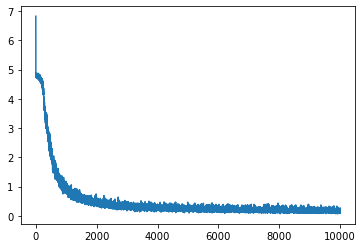

In [6]:
plt.plot(error_list)

In [7]:
feature_extractor.save_weights("/home/lingyu/CL_gaze_project/ETHXgaze/dct_mix_complex_nn/base_1")
projection_head.save_weights("/home/lingyu/CL_gaze_project/ETHXgaze/dct_mix_complex_nn/pro_1")

In [10]:
error_list = np.zeros((70,1))
error_list = error_list.tolist()
subject_num = 70

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# contrastive learning
for epoch in range(50):

    subject_index = np.random.choice(subject_num, subject_num, replace=False)
    episode = 0
    for sub in subject_index:
        index = np.random.choice(pic_num_list[sub], batch_size, replace=False)
        j = 0
        for i in index:
            jpeg_file = '/home/lingyu/CL_gaze_project/ETHXgaze/Pretrain_subject/' + str(sub) + '/' + str(i) + '.jpg'
            img = io.imread(jpeg_file) / 255.
            selected_trans = random.sample(trans_list, 2)
            noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[0])
            noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[1])

            noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image1), selected_trans[1])
            noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image2), selected_trans[0])
            
            noised_image1 = cv2.resize(noised_image1, (224,224))
            noised_image2 = cv2.resize(noised_image2, (224,224))

            noised_image1 *= 255
            noised_image1 = np.round(noised_image1).astype(np.uint8)
            noised_image2 *= 255
            noised_image2 = np.round(noised_image2).astype(np.uint8)
            io.imsave("/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image1.jpg", noised_image1)
            io.imsave("/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image2.jpg", noised_image2)

            jpeg_noised = "/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image1.jpg"
            dct_y, dct_cb, dct_cr = load(jpeg_noised)
            # channel selection
            dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                    np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

            dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
            dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
            cb_cr = np.concatenate([dct_cb, dct_cr], 2)
            query_batch_y[j, :, :, :] = dct_y
            query_batch_cbcr[j, :, :, :] = cb_cr

            jpeg_noised = "/home/lingyu/CL_gaze_project/ETHXgaze/temp_pic/noised_image2.jpg"
            dct_y, dct_cb, dct_cr = load(jpeg_noised)
            # channel selection
            dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                    np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

            dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
            dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
            cb_cr = np.concatenate([dct_cb, dct_cr], 2)
            positive_batch_y[j, :, :, :] = dct_y
            positive_batch_cbcr[j, :, :, :] = cb_cr

            j += 1

        with tf.GradientTape() as tape:

            x1_feature = tf.math.l2_normalize(projection_head(feature_extractor([query_batch_y, query_batch_cbcr], training=True), training=True), axis=1)
            x2_feature = tf.math.l2_normalize(projection_head(feature_extractor([positive_batch_y, positive_batch_cbcr], training=True), training=True), axis=1)

            x1_x2_mat = tf.exp(tf.matmul(x1_feature, tf.transpose(x2_feature)) / tau)

            denominator = tf.reduce_sum(x1_x2_mat, 1)
            #positive_sim = tf.linalg.diag_part(x1_x2_mat)
            prob = x1_x2_mat / tf.reshape(denominator, (x1_feature.shape[0], 1))
            prob = tf.linalg.diag_part(prob)

            loss = -tf.reduce_mean(tf.math.log(prob))

        grads = tape.gradient(loss, feature_extractor.trainable_variables + projection_head.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, feature_extractor.trainable_variables + projection_head.trainable_variables))
        episode += 1
        error_list[sub].append(loss.numpy())
        if episode % 5 == 0:
            print("current epoch: ", epoch, "current episode", episode, "current loss", loss.numpy())

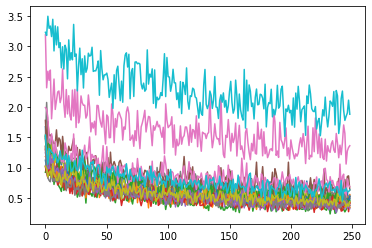

In [14]:
error_list_arr= np.array(error_list)
for sub_fig in range(20):
    plt.plot(error_list_arr[sub_fig][1:-1])

In [15]:
feature_extractor.save_weights("/home/lingyu/CL_gaze_project/ETHXgaze/dct_ours_complex_nn/base_1")
projection_head.save_weights("/home/lingyu/CL_gaze_project/ETHXgaze/dct_ours_complex_nn/pro_1")